In [1]:
import numpy as np
import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
import matplotlib.patches
import PIL.ImageDraw
import PIL.Image
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Dictionary to map file keys from STScI to Krist

In [2]:
prim_key_map = {'hex1':'hex1', 'hex2':'hex2', 'hex3':'hex3', 'hex4':'hex4',
                'key24':'keystone24', 'pie08':'piewedge8', 'pie12':'piewedge12'}
secobs_key_map = {'Cross':'cross', 'X':'x'}

## Set basic parameters

In [37]:
overwrite = True
N = 125 # pupil array quadrant width after binning
iD = 20
oD = 80
aligntol = 4 # units of thousandths of pupil diameter
pad = 7 # units of thousandths of pupil diameter
prim_key = "hex3"
secobs_key = "X"
D = 1000
symm = 'quart' # set to either 'quart' or 'half'
shape = 'hex' # set to 'ann' or 'hex'

In [38]:
#LS_dir = os.path.abspath("../InputMasks/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v2/LS")
LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v3/LS")
#LS_dir = os.path.normpath("/Users/neil/Box Sync/scda/InputMasks/LS")
if not os.path.exists(LS_dir):
    os.mkdir(LS_dir)
    print("created {:s} for LS arrays".format(LS_dir))
else:
    print("Destination {:s} already exists".format(LS_dir))

Destination /astro/opticslab1/SCDA/Apertures/InputMasks_v3/LS already exists


## Load primary mirror and secondary obscuration

In [39]:
#telap_dir = os.path.abspath('../Apertures/JPL/offset_masks')
telap_dir = os.path.normpath('/astro/opticslab1/SCDA/Apertures/JPL/offset_masks')
prim_fname = os.path.join(telap_dir, "{0:s}_{1:04d}pix_offset.fits".format(prim_key_map[prim_key], D))
secobs_fname = os.path.join(telap_dir, "{0:s}_spiders_{1:04d}pix_2.5cm_offset.fits".format(
                                       secobs_key_map[secobs_key], D))
prim_hdulist = fits.open(prim_fname, "readonly")
prim = prim_hdulist[0].data
prim_hdulist.close()
secobs_hdulist = fits.open(secobs_fname, "readonly")
secobs = secobs_hdulist[0].data
secobs_hdulist.close()
telap = prim*secobs

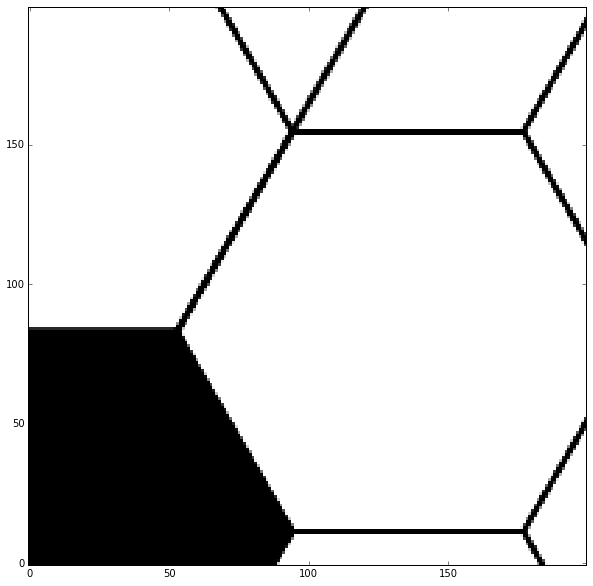

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(telap[500:700,500:700])

## Pad the secondary obscuration

In [41]:
max_shift = int(round(D*float(pad)/1000))
shift_range = range(-max_shift,max_shift+1,1)

In [42]:
[Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)

In [43]:
allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)

In [44]:
allowed_shifts.shape

(15, 15)

In [45]:
XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])

In [46]:
len(XYshifts_allowed)

149

In [47]:
padded_telap_accum = np.ones(telap.shape)
for (xshift,yshift) in XYshifts_allowed:
    telap_shifted = np.roll(np.roll(telap, yshift, 0), xshift, 1) 
    padded_telap_accum *= telap_shifted

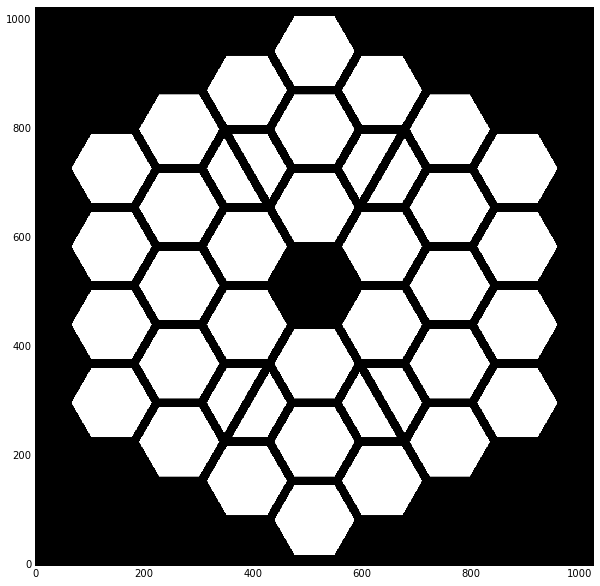

In [48]:
plt.figure(figsize=(10,10))
plt.imshow(padded_telap_accum)

## Combine with annular/hexagonal stop

In [49]:
L = secobs.shape[0]
inD = float(iD)/100
outD = float(oD)/100
xs = np.linspace(-L/2 + 0.5, L/2 - 0.5, L)
[Xs, Ys] = np.meshgrid(xs, xs)

if shape is 'hex':
    xycent = (L/2-0.5,L/2-0.5)
    if prim_key is 'hex1':
        hexagon_obj = matplotlib.patches.RegularPolygon(xycent,6,radius=outD*D/2/np.cos(np.pi/6), orientation=np.pi/6)
    else:
        hexagon_obj = matplotlib.patches.RegularPolygon(xycent,6,radius=outD*D/2/np.cos(np.pi/6))
#        hexagon_obj = matplotlib.patches.RegularPolygon(xycent,6,radius=outD*D/2, orientation=np.pi/6)
    hexagon_verts = hexagon_obj.get_verts()
    hexagon_img = PIL.Image.new('L', secobs.shape, 0)
    PIL.ImageDraw.Draw(hexagon_img).polygon(list(hexagon_verts.ravel()), outline=1, fill=1)
    hexagon_mask = np.array(hexagon_img)
    Lyot_stop = np.logical_and(np.round(padded_telap_accum), hexagon_mask)
    inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
    Lyot_stop[inside_ann] = 0.
else:
    inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
    outside_ann = np.greater_equal(Xs**2 + Ys**2, (outD*D/2)**2)
    Lyot_stop = np.round(padded_telap_accum)
    Lyot_stop[inside_ann] = 0.
    Lyot_stop[outside_ann] = 0.

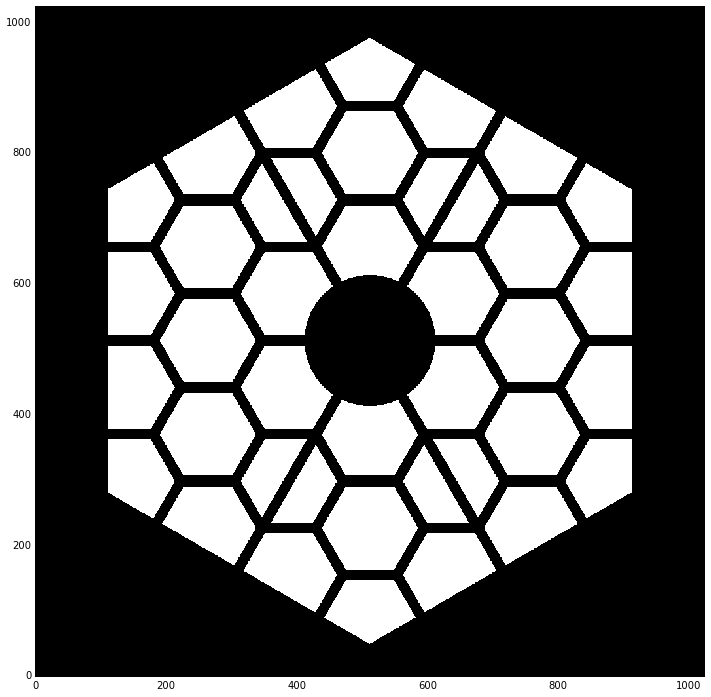

In [50]:
plt.figure(figsize=(12,12))
plt.imshow(Lyot_stop)

## Bin to final array resolution, crop

In [51]:
#scalefac = float(N)/(D/2)
#Lyot_stop_binned = scipy.ndimage.zoom(Lyot_stop, scalefac, order=1)

N_orig = D/2
scalefac = int(N_orig/N)
print("Binning the original LS array {0:d}x".format(scalefac))
Lyot_stop_binned = np.reshape(Lyot_stop, (Lyot_stop.shape[0]/scalefac, scalefac, 
                                          Lyot_stop.shape[1]/scalefac, scalefac)).mean(1).mean(2)
telap_binned = np.reshape(telap, (telap.shape[0]/scalefac, scalefac, 
                                  telap.shape[1]/scalefac, scalefac)).mean(1).mean(2)

Binning the original LS array 4x


In [52]:
L_bin = Lyot_stop_binned.shape[0]
if symm is 'half':
    Lyot_stop_binned_crop = Lyot_stop_binned[L_bin/2-N:L_bin/2+N,L_bin/2:L_bin/2+N]
    Lyot_stop_binned_crop_binary = np.round(Lyot_stop_binned_half).astype(int)
    print Lyot_stop_binned_crop.shape
else:
    Lyot_stop_binned_crop = Lyot_stop_binned[L_bin/2:L_bin/2+N,L_bin/2:L_bin/2+N]
    Lyot_stop_binned_crop_binary = np.round(Lyot_stop_binned_crop).astype(int)
    print Lyot_stop_binned_crop.shape

(125, 125)


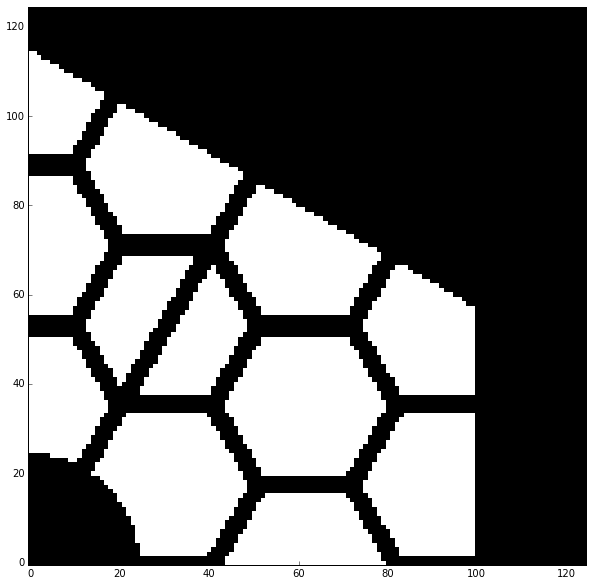

In [53]:
if symm is 'half':
    plt.figure(figsize=(20,10))
    plt.imshow(Lyot_stop_binned_crop_binary)
    #plt.imshow(Lyot_stop_binned_crop)
else:
    plt.figure(figsize=(10,10))
    #plt.imshow(Lyot_stop_binned_crop)
    plt.imshow(Lyot_stop_binned_crop_binary)

## Write the binned, cropped Lyot stop to a dat (ASCII) file 

In [54]:
if symm is 'half':
    LS_dat_fname_tail = "LS_half_{0:s}{1:02d}D{2:02d}_{3:s}{4:s}025cobs1Pad{5:02d}_N{6:04d}.dat".format(
                         shape, int(round(100*inD)), int(round(100*outD)), prim_key, secobs_key, pad, N)
else:
    LS_dat_fname_tail = "LS_quart_{0:s}{1:02d}D{2:02d}_{3:s}{4:s}025cobs1Pad{5:02d}_N{6:04d}.dat".format(
                         shape, int(round(100*inD)), int(round(100*outD)), prim_key, secobs_key, pad, N)

LS_dat_fname = os.path.join(LS_dir, LS_dat_fname_tail)

if not os.path.exists(LS_dat_fname) or overwrite==True:
    #np.savetxt(LS_dat_fname, Lyot_stop_binned_crop, fmt='%.6f', delimiter=" ")
    np.savetxt(LS_dat_fname, Lyot_stop_binned_crop_binary, fmt='%d', delimiter=" ")
    print("Wrote binned, cropped LS array to {0:s}".format(LS_dat_fname))
else:
    print("LS array {0:s} already exists, will not overwrite".format(LS_dat_fname))

Wrote binned, cropped LS array to /astro/opticslab1/SCDA/Apertures/InputMasks_v3/LS/LS_quart_hex20D80_hex3X025cobs1Pad07_N0125.dat


In [55]:
os.listdir(LS_dir)

['LS_quart_ann20D76_hex1X025cobs1Pad05_N0250.dat',
 'LDZ_quart_ann20D76_hex1X025cobs1Pad05_Tol02_N0250.dat',
 'LS_quart_ann20D110_hex1X025cobs1Pad05_N0250.dat',
 'LDZ_quart_ann20D110_hex1X025cobs1Pad05_Tol02_N0250.dat',
 'LS_quart_ann20D76_clear_N0250.dat',
 'LDZ_quart_ann20D76_clear_Tol03_N0250.dat',
 'LS_quart_hex20D80_hex3X025cobs1Pad07_N0125.dat',
 'LDZ_quart_hex20D80_hex3X025cobs1Pad07_Tol04_N0125.dat',
 'LS_quart_hex20D90_hex1X025cobs1Pad07_N0125.dat',
 'LDZ_quart_hex20D90_hex1X025cobs1Pad07_Tol04_N0125.dat',
 'LS_quart_hex20D80_clear_N0250.dat']

In [56]:
# os.remove(LS_dat_fname)

# Define Lyot plane dark zone

In [57]:
orig_LS = np.round(Lyot_stop_binned[L_bin/2-N:L_bin/2+N,L_bin/2-N:L_bin/2+N]).astype(int)
orig_telap = telap_binned[L_bin/2-N:L_bin/2+N,L_bin/2-N:L_bin/2+N]
dz_width_fac = float(aligntol)/1000              # dark zone is +/- this fraction of pupil diameter
dz_width = np.ceil(2*N*dz_width_fac).astype(int) # dark zone is +/- this number of pixels in binned pupil array
print("Lyot plane dark zone width in binned array: +/- {:d} pixels".format(dz_width))

Lyot plane dark zone width in binned array: +/- 1 pixels


In [58]:
max_shift = dz_width
shift_range = range(-max_shift,max_shift+1,1)
[Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)
allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)

In [59]:
allowed_shifts

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]], dtype=bool)

In [60]:
XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])
len(XYshifts_allowed)

5

In [61]:
fat_LS = np.ones(orig_LS.shape)
for (xshift,yshift) in XYshifts_allowed:
    LS_shifted = np.roll(np.roll(orig_LS, yshift, 0), xshift, 1)
    fat_LS *= LS_shifted

inv_thin_LS = np.ones(orig_LS.shape)
for (xshift,yshift) in XYshifts_allowed:
    inv_LS_shifted = 1-np.roll(np.roll(orig_LS, yshift, 0), xshift, 1)
    inv_thin_LS *= inv_LS_shifted
thin_LS = 1-inv_thin_LS

In [62]:
Lyot_dz = np.logical_xor(thin_LS, fat_LS)
L = Lyot_dz.shape[0]

if symm is 'half':
    Lyot_dz_crop = Lyot_dz[:,N:]
else:
    Lyot_dz_crop = Lyot_dz[N:,N:]

#plt.figure(figsize=(16,16))
#plt.imshow(Lyot_dz)

In [63]:
#plt.figure(figsize=(16,16))
#plt.imshow(1-np.floor(orig_telap))
#plt.imshow(np.logical_and(Lyot_dz,1-np.floor(orig_telap)))

print("None of the zero-valued telescope aperture points intersect with the Lyot constraint region? {:}".format(
        ~np.any(np.logical_and(Lyot_dz,1-np.floor(orig_telap)))))

None of the zero-valued telescope aperture points intersect with the Lyot constraint region? True


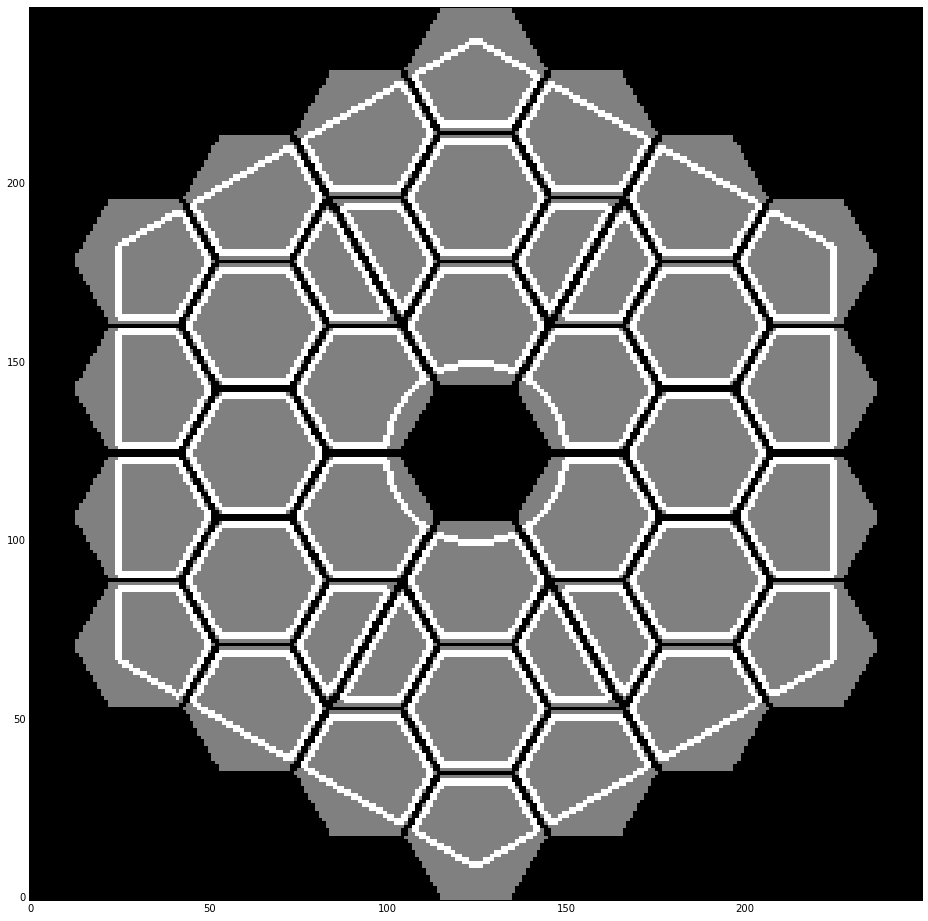

In [64]:
plt.figure(figsize=(16,16))
#plt.imshow(orig_telap)
#plt.imshow(np.floor(orig_telap).astype(int))
plt.imshow(Lyot_dz-(1-np.floor(orig_telap)),cmap='gray')

## Alignment tolerance check

In [65]:
max_shift_tol = 2*N*dz_width_fac
max_shift_tol_int = int(np.floor(max_shift_tol))
test_shift = (max_shift_tol_int,0)
print("The LDZ accomomdates a translation +/-{0:.1f}% of D={1:d} pixels = +/-{2:.2f} pixels, up to +/-{3:d} whole pixels".format(
      float(aligntol)/10, 2*N, max_shift_tol, max_shift_tol_int))
print("Testing an (x,y) translation of {0:} pixels. Within the design tolerance? {1:}".format(
      test_shift, test_shift[0]**2 + test_shift[1]**2 <= max_shift_tol))
shift_LS = np.roll(np.roll(orig_LS, test_shift[0], axis=1), test_shift[1], axis=0)
LS_err_mask = np.ceil(np.abs(shift_LS - orig_LS)).astype(bool)

LDZ_valid = ~np.any(np.logical_and(LS_err_mask, ~Lyot_dz))
print("LDZ encompasses the LS transmission error region? {0:}".format(LDZ_valid))

print("Total unconstrained \"leak\" area after translation = {0:d} pixels".format(
      int(np.sum(np.logical_and(LS_err_mask, ~Lyot_dz)))))

The LDZ accomomdates a translation +/-0.4% of D=250 pixels = +/-1.00 pixels, up to +/-1 whole pixels
Testing an (x,y) translation of (1, 0) pixels. Within the design tolerance? True
LDZ encompasses the LS transmission error region? True
Total unconstrained "leak" area after translation = 0 pixels


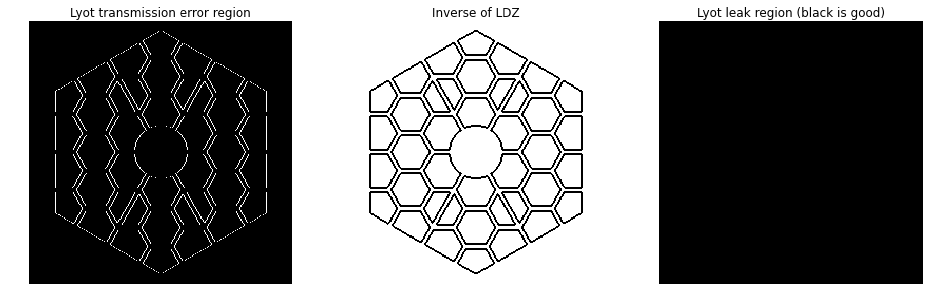

In [66]:
plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(LS_err_mask)
lims = plt.axis('off')
t=plt.title('Lyot transmission error region')
plt.subplot(132)
plt.imshow(~Lyot_dz)
lims = plt.axis('off')
t=plt.title('Inverse of LDZ')
plt.subplot(133)
plt.imshow(np.logical_and(LS_err_mask, ~Lyot_dz))
lims = plt.axis('off')
t=plt.title('Lyot leak region (black is good)')

## Write the Lyot dark zone file

In [67]:
if aligntol > 0 and LDZ_valid:
    if symm is 'half':
        LDZ_dat_fname_tail = "LDZ_half_{0:s}{1:02d}D{2:02d}_{3:s}{4:s}025cobs1Pad{5:02d}_Tol{6:02d}_N{7:04d}.dat".format(
                              shape, int(round(100*inD)), int(round(100*outD)), prim_key,
                              secobs_key, pad, aligntol, N)
    else:
        LDZ_dat_fname_tail = "LDZ_quart_{0:s}{1:02d}D{2:02d}_{3:s}{4:s}025cobs1Pad{5:02d}_Tol{6:02d}_N{7:04d}.dat".format(
                              shape, int(round(100*inD)), int(round(100*outD)), prim_key,
                              secobs_key, pad, aligntol, N)

    LDZ_dat_fname = os.path.join(LS_dir, LDZ_dat_fname_tail)
    
    if not os.path.exists(LDZ_dat_fname) or overwrite==True:
        np.savetxt(LDZ_dat_fname, Lyot_dz_crop, fmt='%d', delimiter=" ")
        print("Wrote binned, cropped LDZ array to {0:s}".format(LDZ_dat_fname))
    else:
        print("LDZ array {0:s} already exists, will not overwrite".format(LDZ_dat_fname))

Wrote binned, cropped LDZ array to /astro/opticslab1/SCDA/Apertures/InputMasks_v3/LS/LDZ_quart_hex20D80_hex3X025cobs1Pad07_Tol04_N0125.dat


In [68]:
Lyot_dz_crop.shape

(125, 125)

In [69]:
# os.remove(LDZ_dat_fname)

In [70]:
os.listdir(LS_dir)

['LS_quart_ann20D76_hex1X025cobs1Pad05_N0250.dat',
 'LDZ_quart_ann20D76_hex1X025cobs1Pad05_Tol02_N0250.dat',
 'LS_quart_ann20D110_hex1X025cobs1Pad05_N0250.dat',
 'LDZ_quart_ann20D110_hex1X025cobs1Pad05_Tol02_N0250.dat',
 'LS_quart_ann20D76_clear_N0250.dat',
 'LDZ_quart_ann20D76_clear_Tol03_N0250.dat',
 'LS_quart_hex20D80_hex3X025cobs1Pad07_N0125.dat',
 'LDZ_quart_hex20D80_hex3X025cobs1Pad07_Tol04_N0125.dat',
 'LS_quart_hex20D90_hex1X025cobs1Pad07_N0125.dat',
 'LDZ_quart_hex20D90_hex1X025cobs1Pad07_Tol04_N0125.dat',
 'LS_quart_hex20D80_clear_N0250.dat']